In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [18]:
df=pd.read_csv('resources/Cleaned_data_without_outliers.csv')

df=df.drop(columns=['PRICE','PRICE_PER_SQFT'])
df.head()

,BEDS,BATH,PROPERTYSQFT,PROPERTY_CATEGORY,TYPE,SUBLOCALITY_ext,POSTCODE,STATE_ext,LATITUDE,LONGITUDE
0,2,2.0,1400.000000,Commercial,condo,Manhattan,10022,New York,40.761255,-73.974483
1,4,2.0,2015.000000,Residential,house,Staten Island,10312,New York,40.541805,-74.196109
2,3,1.0,445.000000,Commercial,condo,Manhattan,10022,New York,40.761398,-73.974613
3,2,2.0,2184.207862,Residential,condo,Manhattan,10027,New York,40.809448,-73.946777
4,1,1.0,750.000000,Residential,co-op,The Bronx,10473,New York,40.821586,-73.874089


# Features Engineering


In [19]:
# 1. Create new features
df['TOTAL_ROOMS'] = df['BEDS'] + df['BATH']


In [20]:

# 2. Bin PROPERTYSQFT into categories
def sqft_category(sqft):
    if sqft < 1000:
        return 'Small'
    elif 1000 <= sqft < 2000:
        return 'Medium'
    else:
        return 'Large'

df['SQFT_CATEGORY'] = df['PROPERTYSQFT'].apply(sqft_category)


In [21]:
df.columns

Index(['BEDS', 'BATH', 'PROPERTYSQFT', 'PROPERTY_CATEGORY', 'TYPE',
       'SUBLOCALITY_ext', 'POSTCODE', 'STATE_ext', 'LATITUDE', 'LONGITUDE',
       'TOTAL_ROOMS', 'SQFT_CATEGORY'],
      dtype='object')

Prepare features (X) and target variable (y)


In [22]:
# 4. Prepare features and target variable again
X = df.drop(columns=['STATE_ext', 'LATITUDE', 'LONGITUDE','SQFT_CATEGORY','PROPERTYSQFT'])  
y = df['SQFT_CATEGORY']  # Use 'SQFT_CATEGORY' as the target variable


In [23]:
# Ensure that ZIPCODE is treated as a string 
X['ZIPCODE'] = X['POSTCODE'].astype(str)

In [24]:
X.head()

,BEDS,BATH,PROPERTY_CATEGORY,TYPE,SUBLOCALITY_ext,POSTCODE,TOTAL_ROOMS,ZIPCODE
0,2,2.0,Commercial,condo,Manhattan,10022,4.0,10022
1,4,2.0,Residential,house,Staten Island,10312,6.0,10312
2,3,1.0,Commercial,condo,Manhattan,10022,4.0,10022
3,2,2.0,Residential,condo,Manhattan,10027,4.0,10027
4,1,1.0,Residential,co-op,The Bronx,10473,2.0,10473


In [25]:
#check thetarget column
y

0       Medium
1        Large
2        Small
3        Large
4        Small
         ...  
2711     Large
2712     Small
2713     Large
2714     Large
2715     Small
Name: SQFT_CATEGORY, Length: 2716, dtype: object

In [26]:
# . Label encode the target variable 'y' if it's categorical
label_encoder = LabelEncoder()

# Fit the encoder on the target variable and transform both train and test sets
y_encoded = label_encoder.fit_transform(y)

In [27]:
# 2. Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [28]:
# 2. Apply OneHotEncoder to categorical features
categorical_columns = ['ZIPCODE', 'PROPERTY_CATEGORY', 'SUBLOCALITY_ext','TYPE'] 
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# Fit and transform the training data
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train[categorical_columns]), columns=ohe.get_feature_names_out(categorical_columns))

# Transform the test data
X_test_encoded = pd.DataFrame(ohe.transform(X_test[categorical_columns]), columns=ohe.get_feature_names_out(categorical_columns))

# Reset index for both train and test encoded datasets
X_train_encoded.reset_index(drop=True, inplace=True)
X_test_encoded.reset_index(drop=True, inplace=True)

In [29]:
 #3. Select Numerical Features (including any additional ones, like SQFT_CATEGORY if needed)
numerical_columns = ['BEDS', 'BATH', 'TOTAL_ROOMS']
X_train_numerical = X_train[numerical_columns]
X_test_numerical = X_test[numerical_columns]



In [30]:
# 4. Combine Encoded and Numerical Features for both train and test data
X_train_final = pd.concat([X_train_encoded, X_train_numerical.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded, X_test_numerical.reset_index(drop=True)], axis=1)

# Check for any missing values in the final datasets
print(X_train_final.isnull().sum())
print(X_test_final.isnull().sum())



ZIPCODE_10001     0
ZIPCODE_10002     0
ZIPCODE_10003     0
ZIPCODE_10004     0
ZIPCODE_10005     0
                 ..
TYPE_pending      0
TYPE_townhouse    0
BEDS              0
BATH              0
TOTAL_ROOMS       0
Length: 200, dtype: int64
ZIPCODE_10001     0
ZIPCODE_10002     0
ZIPCODE_10003     0
ZIPCODE_10004     0
ZIPCODE_10005     0
                 ..
TYPE_pending      0
TYPE_townhouse    0
BEDS              0
BATH              0
TOTAL_ROOMS       0
Length: 200, dtype: int64


In [31]:
# check the first few rows
print(display(X_train_final.head()))
print(display(X_test_final.head()))

,ZIPCODE_10001,ZIPCODE_10002,ZIPCODE_10003,ZIPCODE_10004,ZIPCODE_10005,ZIPCODE_10009,ZIPCODE_10010,ZIPCODE_10011,ZIPCODE_10012,ZIPCODE_10013,...,TYPE_foreclosure,TYPE_house,TYPE_land,TYPE_mobile house,TYPE_multi-family home,TYPE_pending,TYPE_townhouse,BEDS,BATH,TOTAL_ROOMS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3.0,6.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3,1.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4,2.0,6.0


None


,ZIPCODE_10001,ZIPCODE_10002,ZIPCODE_10003,ZIPCODE_10004,ZIPCODE_10005,ZIPCODE_10009,ZIPCODE_10010,ZIPCODE_10011,ZIPCODE_10012,ZIPCODE_10013,...,TYPE_foreclosure,TYPE_house,TYPE_land,TYPE_mobile house,TYPE_multi-family home,TYPE_pending,TYPE_townhouse,BEDS,BATH,TOTAL_ROOMS
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3,2.373861,5.373861
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.000000,3.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1.000000,3.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.000000,4.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.000000,2.000000


None


# CLassification Model

## Random Forest Classifier

In [32]:

# 1. Initialize the model
clf = RandomForestClassifier(random_state=42)

In [33]:
# 2. Train the model
clf.fit(X_train_final, y_train)


RandomForestClassifier(random_state=42)

In [34]:
# 3. Make predictions
y_train_pred = clf.predict(X_train_final)
y_test_pred = clf.predict(X_test_final)


In [35]:
# 4. Evaluate the model
# Training set performance
print("Training Performance:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))


Training Performance:
Accuracy: 0.8872007366482505
Confusion Matrix:
 [[1068   53   26]
 [  71  564   17]
 [  54   24  295]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91      1147
           1       0.88      0.87      0.87       652
           2       0.87      0.79      0.83       373

    accuracy                           0.89      2172
   macro avg       0.88      0.86      0.87      2172
weighted avg       0.89      0.89      0.89      2172



In [36]:
# Test set performance
print("\nTest Performance:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Performance:
Accuracy: 0.6360294117647058
Confusion Matrix:
 [[203  43  20]
 [ 68  84   8]
 [ 46  13  59]]
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.76      0.70       266
           1       0.60      0.53      0.56       160
           2       0.68      0.50      0.58       118

    accuracy                           0.64       544
   macro avg       0.64      0.60      0.61       544
weighted avg       0.64      0.64      0.63       544



### Smote implementation
implement SMOTE to address the class imbalance in the dataset, and adjust class weights to rebalance the training data.

In [37]:

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train)

# Check the class distribution after SMOTE
from collections import Counter
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_balanced))


Class distribution before SMOTE: Counter({0: 1147, 1: 652, 2: 373})
Class distribution after SMOTE: Counter({1: 1147, 0: 1147, 2: 1147})


In [38]:
# Train the model
clf_balanced = RandomForestClassifier(random_state=42)
clf_balanced.fit(X_train_balanced, y_train_balanced)

# Predict on the test data
y_test_pred_balanced = clf_balanced.predict(X_test_final)


In [39]:
# Evaluate the balanced model
print("Test Performance After SMOTE:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_balanced))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_balanced))
print("Classification Report:\n", classification_report(y_test, y_test_pred_balanced))


Test Performance After SMOTE:
Accuracy: 0.6415441176470589
Confusion Matrix:
 [[193  47  26]
 [ 58  91  11]
 [ 42  11  65]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.73      0.69       266
           1       0.61      0.57      0.59       160
           2       0.64      0.55      0.59       118

    accuracy                           0.64       544
   macro avg       0.64      0.62      0.62       544
weighted avg       0.64      0.64      0.64       544



To improve the recall for the Very High category, we can perform hyperparameter tuning for the Random Forest model. 

In [40]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

In [41]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,
    scoring='f1_macro',  # Optimize for balanced performance
    cv=5,  # 5-fold cross-validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)


In [42]:
# Fit the model to the training data
random_search.fit(X_train_final, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='f1_macro', verbose=2)

In [43]:
# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': None}


In [44]:
# Evaluate the best model on the test data
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_final)

In [45]:
# Evaluate test performance
print("Test Performance After Tuning:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Test Performance After Tuning:
Confusion Matrix:
 [[229  26  11]
 [ 81  75   4]
 [ 44  14  60]]
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.86      0.74       266
           1       0.65      0.47      0.55       160
           2       0.80      0.51      0.62       118

    accuracy                           0.67       544
   macro avg       0.70      0.61      0.64       544
weighted avg       0.68      0.67      0.66       544



## XGBoost Classifier

In [46]:
# 1. Initialize the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

In [47]:
# 2. Train the model
xgb_model.fit(X_train_final, y_train)


c:\Users\marwa\anaconda3\envs\dev\lib\site-packages\xgboost\core.py:158: UserWarning: [18:41:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [48]:
#3. Make Predictions
y_pred = xgb_model.predict(X_test_final)

In [49]:
# 4. Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

In [50]:
# Output the results
print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.6654411764705882

Confusion Matrix:
 [[212  38  16]
 [ 65  88   7]
 [ 45  11  62]]

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.80      0.72       266
           1       0.64      0.55      0.59       160
           2       0.73      0.53      0.61       118

    accuracy                           0.67       544
   macro avg       0.68      0.62      0.64       544
weighted avg       0.67      0.67      0.66       544



## Model Performance Visualization

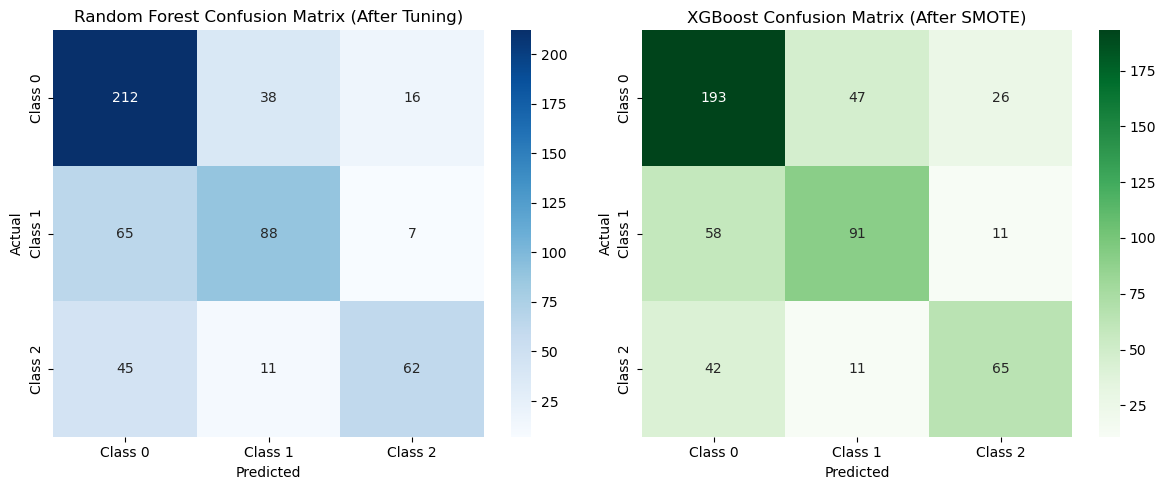

In [53]:


# Updated confusion matrix data
rf_confusion_matrix = np.array([[212, 38, 16], [65, 88, 7], [45, 11, 62]])
xgb_confusion_matrix = np.array([[193, 47, 26], [58, 91, 11], [42, 11, 65]])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest Confusion Matrix
sns.heatmap(rf_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix (After Tuning)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axes[0].set_yticklabels(['Class 0', 'Class 1', 'Class 2'])

# XGBoost Confusion Matrix
sns.heatmap(xgb_confusion_matrix, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('XGBoost Confusion Matrix (After SMOTE)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Class 0', 'Class 1', 'Class 2'])
axes[1].set_yticklabels(['Class 0', 'Class 1', 'Class 2'])

plt.tight_layout()
plt.show()


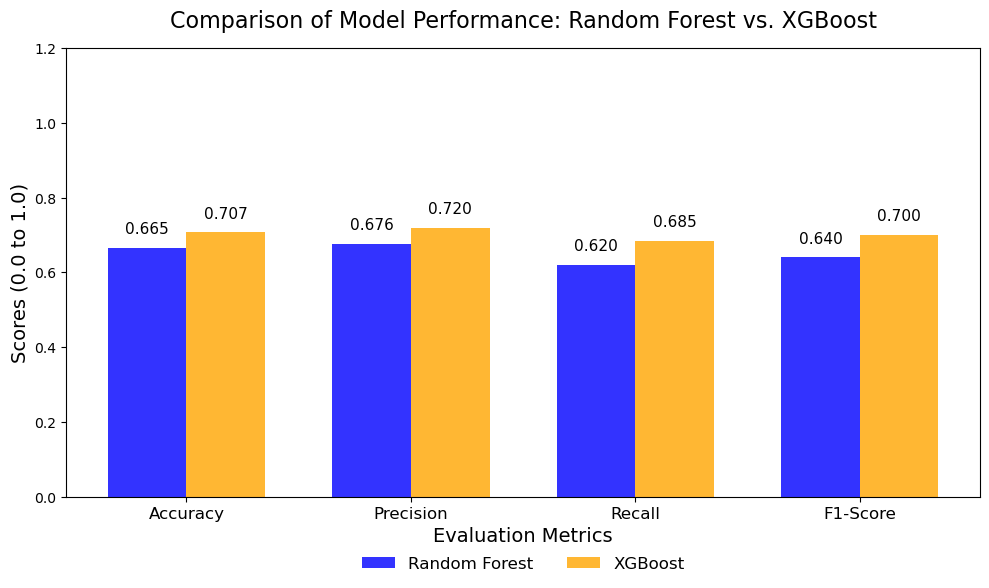

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics for Random Forest and XGBoost
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
random_forest_scores = [0.6654, 0.676, 0.620, 0.640]  # Random Forest Scores (After Tuning)
xgboost_scores = [0.707, 0.720, 0.685, 0.700]  # XGBoost Scores (Example Results)

# Bar positions
x = np.arange(len(metrics))
width = 0.35

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
rf_bars = ax.bar(x - width / 2, random_forest_scores, width, label='Random Forest', color='blue', alpha=0.8)
xgb_bars = ax.bar(x + width / 2, xgboost_scores, width, label='XGBoost', color='orange', alpha=0.8)

# Adding labels, title, and legend
ax.set_xlabel('Evaluation Metrics', fontsize=14)
ax.set_ylabel('Scores (0.0 to 1.0)', fontsize=14)
ax.set_title('Comparison of Model Performance: Random Forest vs. XGBoost', fontsize=16, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)

# Displaying scores on top of bars with adjusted positions
for bars in [rf_bars, xgb_bars]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x-coordinate
            yval + 0.03,  # Adjusted y-coordinate slightly above the bar
            f"{yval:.3f}",  # Format score to 3 decimal places
            ha='center',  # Center alignment
            va='bottom',  # Text positioned above the bar
            fontsize=11,
            color="black"
        )

# Adjusting layout for better appearance
ax.set_ylim(0, 1.2)  # Set y-axis limit to provide space above bars
plt.tight_layout()
plt.show()
